In [61]:
import uuid
from pprint import pprint
import os
import requests
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import sched, time
import random

secrets = open('/Users/josephyusufov/kalshi/secrets.json')
secrets = json.load(secrets)

KALSHI_HOST = secrets['KALSHI_HOST']
KALSHI_USERNAME = secrets['KALSHI_USERNAME']
KASLHI_PASSWORD = secrets['KASLHI_PASSWORD']

url = KALSHI_HOST + '/login'
headers = {
    "accept": "application/json",
    "content-type": "application/json"
}
body = {
    "email": KALSHI_USERNAME,
    "password": KASLHI_PASSWORD
}
response = requests.post(url, headers=headers, json=body)
token = response.json()['token']

In [62]:
def collectOBData(market): 
    # schedule the next call first
    # scheduler.enter(60, 1, collectOBData, (market, scheduler))
    # then do your stuff
    df = pd.DataFrame({
        "ts": pd.Series(dtype="int"),
        "yes": pd.Series(dtype="float"),
        "no": pd.Series(dtype="float"),
    })
    starttime = time.monotonic()
    for i in range(50):
        url = KALSHI_HOST + "/markets/%s/orderbook?depth=1" % (market)
        headers = {
            "accept": "application/json",
            "Authorization": "Bearer " + token
        }
        response = requests.get(url, headers=headers)
        res = response.json()
        res = res['orderbook']
        res['ts'] =  int(time.time())
        res['yes'] = [res['yes'][0][0]]
        res['no'] = [res['no'][0][0]]
        df = pd.concat([df, pd.DataFrame(res)])
        time.sleep(0.2)
    return df

def arbit(market): 
    for i in range(10):
        url = KALSHI_HOST + "/markets/%s/orderbook?depth=1" % (market)
        headers = {
            "accept": "application/json",
            "Authorization": "Bearer " + token
        }
        res = requests.get(url, headers=headers).json()['orderbook']
        yes_bid = res['yes'][0][0] 
        no_bid = res['no'][0][0] 
        premium = 100 - yes_bid - no_bid
        if premium >= 3:
            print(premium)
            print("sending order")
            url = KALSHI_HOST + "/portfolio/orders/batched"
            payload = {
                "orders": [
                    {
                        "action": "buy",
                        "count": 1,
                        "expiration_ts": 1,
                        "side": "yes",
                        "yes_price": yes_bid + 1,
                        "type": "limit",
                        "ticker": market,
                        "client_order_id": i
                    },
                    {
                        "action": "buy",
                        "count": 1,
                        "expiration_ts": 1,
                        "side": "no",
                        "no_price": no_bid + 1,
                        "type": "limit",
                        "ticker": market,
                        "client_order_id": i + 1000
                    }
                ]
            }
            pprint(payload)
            headers = {
                "accept": "application/json",
                "content-type": "application/json"
            }
            response = requests.post(url, json=payload, headers=headers)
            print(response.json())
        time.sleep(0.2)
collectOBData("INXD-24DEC31-T5799.99")
# arbit("INX-24APR12-T4975")


,ts,yes,no
0,1712953504,22.0,76.0
0,1712953504,22.0,76.0
0,1712953505,22.0,76.0
0,1712953505,22.0,76.0
0,1712953506,22.0,76.0
0,1712953506,22.0,76.0
0,1712953506,22.0,76.0
0,1712953507,22.0,76.0
0,1712953507,22.0,76.0
0,1712953508,22.0,76.0


In [72]:
market = "INXD-24DEC31-T5799.99"
url = KALSHI_HOST + "/markets/%s/orderbook?depth=1" % (market)
headers = {
    "accept": "application/json",
    "Authorization": "Bearer " + token
}
print(token)
res = requests.get(url, headers=headers).json()['orderbook']
print(res)
yes_bid = res['yes'][0][0] 
no_bid = res['no'][0][0] 
premium = 100 - yes_bid - no_bid

url = KALSHI_HOST + "/portfolio/orders"
payload = {
            'ticker': market,
            'client_order_id':str(uuid.uuid4()),
            'type':'limit',
            'action':'buy',
            'side':'yes',
            'count':1,
            'yes_price':yes_bid + 1, # yes_price = 100 - no_price
            'no_price':None, # no_price = 100 - yes_price
            'expiration_ts':None,
            'sell_position_floor':None,
            'buy_max_cost':None
}
pprint(payload)
headers = {
    "accept": "application/json",
    "content-type": "application/json"
}
response = requests.post(url, json=payload, headers=headers)
print(response.json())

fc2f661d-0f50-4c6c-bb92-75bda4d82960:Br8Qsb2V1IgcHLmM9PPjIKq0jhQO5VM3joozIHYcPPCs50H06TWQTHB1F6qQvscA
{'yes': [[22, 1000]], 'no': [[76, 100000]]}
{'action': 'buy',
 'buy_max_cost': None,
 'client_order_id': '98123013-1d4d-4511-81d7-25cd1d14f033',
 'count': 1,
 'expiration_ts': None,
 'no_price': None,
 'sell_position_floor': None,
 'side': 'yes',
 'ticker': 'INXD-24DEC31-T5799.99',
 'type': 'limit',
 'yes_price': 23}
{'error': {'code': 'missing_parameters', 'message': 'missing parameters', 'service': ''}}


<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 0 to 0
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ts       50 non-null     int64  
 1   yes      50 non-null     float64
 2   no       50 non-null     float64
 3   premium  50 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 2.0 KB


array([[<Axes: title={'center': 'premium'}>]], dtype=object)

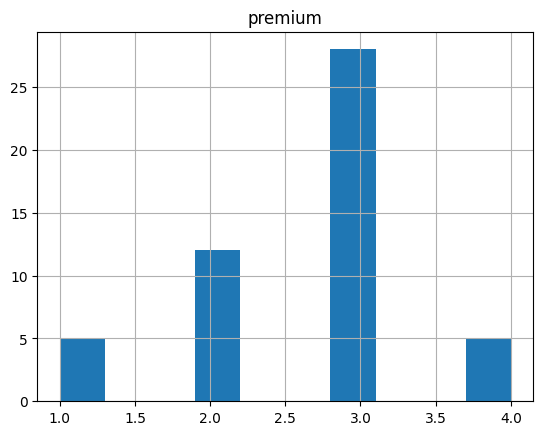

In [27]:
df["premium"] = 100 - df["yes"] - df["no"]
df.info()
df.hist(column="premium")